In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score, roc_auc_score, roc_curve, auc ,precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Constant Varaibles

In [ ]:

BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 25
n_classes = 8

# Preprocessing and Loading Dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Variant-a(Multiclass Classification)",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4525 files belonging to 3 classes.


# Class Names

In [ ]:
class_names = dataset.class_names
class_names

['test', 'train', 'val']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 1 1 1 2 1 1 1 0 0 1 0 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1]


# Train Datasets

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Variant-a(Multiclass Classification)/train",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3162 files belonging to 8 classes.


# Test Datasets

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Variant-a(Multiclass Classification)/test",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 461 files belonging to 8 classes.


# Vaid datasets

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Variant-a(Multiclass Classification)/val",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 902 files belonging to 8 classes.


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)


# Data Augmentations

In [ ]:
# Create data augmentation layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Models Merging

In [ ]:

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Make some layers trainable in VGG19
for layer in vgg19_model.layers[-12:]:
    layer.trainable = True


inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Make some layers trainable in InceptionV3
for layer in inception_model.layers[-20:]:
    layer.trainable = True


input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = resize_and_rescale(input_layer)
x = data_augmentation(x)

vgg19_output = vgg19_model(x)

inception_output = inception_model(x)


vgg19_output = layers.GlobalAveragePooling2D()(vgg19_output)
inception_output = layers.GlobalAveragePooling2D()(inception_output)


concatenated = layers.Concatenate()([vgg19_output, inception_output])

dense1 = layers.Dense(512, activation='relu')(concatenated)
dropout1 = layers.Dropout(0.5)(dense1)

output_layer = layers.Dense(8, activation='softmax')(dropout1)

model = models.Model(inputs=input_layer, outputs=output_layer)

# Model Summary

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 224, 224, 3)          0         ['sequential_2[0][0]']        
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['sequential_3[0][0]']        
                                                          4                                 

# Compiling Model

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define an early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[lr_schedule]
)

Epoch 1/25
99/99 [==============================] - 151s 1s/step - loss: 1.4784 - accuracy: 0.4870 - val_loss: 1.1548 - val_accuracy: 0.5909 - lr: 1.0000e-04
Epoch 2/25
99/99 [==============================] - 104s 1s/step - loss: 1.0063 - accuracy: 0.6423 - val_loss: 1.1197 - val_accuracy: 0.6563 - lr: 1.0000e-04
Epoch 3/25
99/99 [==============================] - 103s 1s/step - loss: 0.7829 - accuracy: 0.7236 - val_loss: 1.1641 - val_accuracy: 0.5931 - lr: 1.0000e-04
Epoch 4/25
99/99 [==============================] - 103s 1s/step - loss: 0.6685 - accuracy: 0.7600 - val_loss: 0.9205 - val_accuracy: 0.6929 - lr: 1.0000e-04
Epoch 5/25
99/99 [==============================] - 103s 1s/step - loss: 0.5734 - accuracy: 0.7989 - val_loss: 0.8657 - val_accuracy: 0.7184 - lr: 1.0000e-04
Epoch 6/25
99/99 [==============================] - 103s 1s/step - loss: 0.4923 - accuracy: 0.8210 - val_loss: 1.1771 - val_accuracy: 0.6774 - lr: 9.0484e-05
Epoch 7/25
99/99 [==============================] - 

# Model History

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 99}

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

# Model Accuracy for first 5 Epochs

In [ ]:
history.history['accuracy'][:5] # show loss for first 5 epochs

[0.48703351616859436,
 0.6423149704933167,
 0.7235926389694214,
 0.7599620223045349,
 0.7988615036010742]

# Table Representation of Model Epochs

In [ ]:
import pandas as pd
from tabulate import tabulate

# Assuming history is a dictionary with relevant metrics
history_metrics = {
    'Epoch': range(1, 24),  # Assuming you want the first 7 epochs
    'Val_Loss': history.history['val_loss'][:23],
    'Val_Accuracy': history.history['val_accuracy'][:23],
    'Loss': history.history['loss'][:23],
    'Accuracy': history.history['accuracy'][:23]
}

# Creating a DataFrame
df = pd.DataFrame(history_metrics)

# Limiting decimal places to two
df = df.round(2)

df.to_csv('history_metrics.csv', index=False)

# Displaying the DataFrame in a tabulated format
table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)


╒═════════╤════════════╤════════════════╤════════╤════════════╕
│   Epoch │   Val_Loss │   Val_Accuracy │   Loss │   Accuracy │
╞═════════╪════════════╪════════════════╪════════╪════════════╡
│       1 │       1.15 │           0.59 │   1.48 │       0.49 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       2 │       1.12 │           0.66 │   1.01 │       0.64 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       3 │       1.16 │           0.59 │   0.78 │       0.72 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       4 │       0.92 │           0.69 │   0.67 │       0.76 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       5 │       0.87 │           0.72 │   0.57 │       0.8  │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       6 │       1.18 │           0.68 │   0.49 │       0.82 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       7 │       0.83 │           0.73 

# Training and Validation Loss & Accuracy

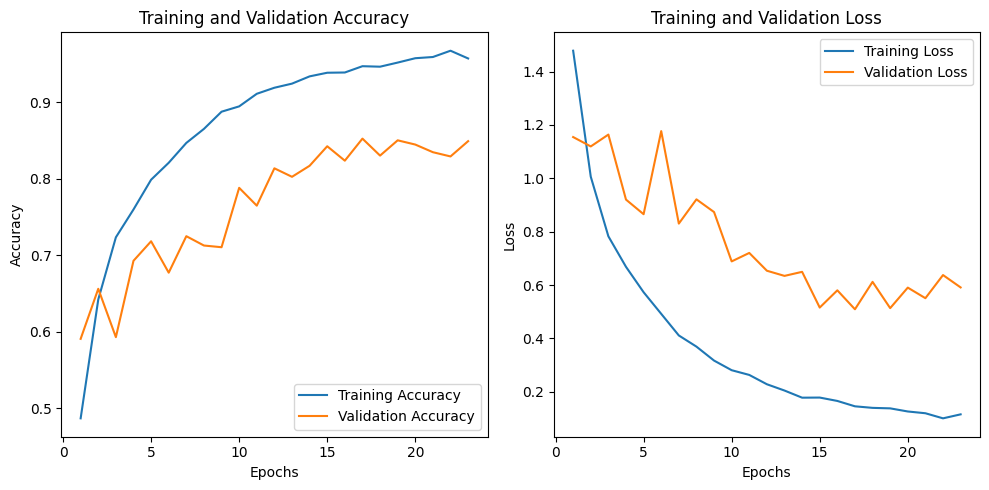

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'][:23]
val_acc = history.history['val_accuracy'][:23]
loss = history.history['loss'][:23]
val_loss = history.history['val_loss'][:23]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot position 1
plt.plot(range(1, 24), acc, label='Training Accuracy')
plt.plot(range(1, 24), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot position 2
plt.plot(range(1, 24), loss, label='Training Loss')
plt.plot(range(1, 24), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.savefig('training_plot.png')

plt.tight_layout()  # To adjust the spacing between subplots
plt.show()


# Model Performace

In [ ]:
model.evaluate(test_ds)

15/15 [==============================] - 4s 209ms/step - loss: 0.4429 - accuracy: 0.8872


[0.44289910793304443, 0.887201726436615]

In [ ]:
class_names = ['Early_blight', 'Healthy', 'Late_blight','Leaf Miner','Magnesium Deficiency','Nitrogen Deficiency','Pottassium Deficiency','Spotted Wilt Virus']  # Make sure it matches your dataset


# Predicting from Test Dataset

first image to predict
actual label: Late_blight
1/1 [==============================] - 0s 36ms/step
predicted label: Leaf Miner


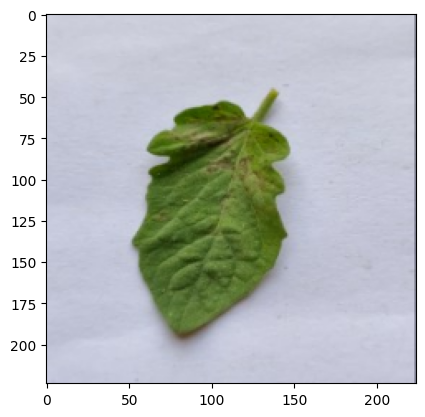

In [ ]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)




first image to predict
actual label: Late_blight
1/1 [==============================] - 0s 120ms/step
predicted label: Late_blight


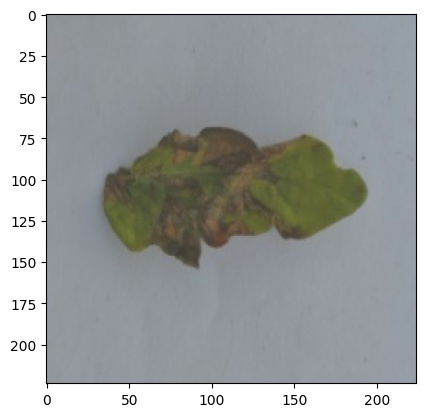

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Predicted and Actual Labels

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 33ms/step
predicted label 1: Late_blight
predicted label 2: Leaf Miner
predicted label 3: Magnesium Deficiency
predicted label 4: Leaf Miner
predicted label 5: Early_blight
predicted label 6: Healthy
predicted label 7: Leaf Miner
predicted label 8: Magnesium Deficiency
predicted label 9: Early_blight
predicted label 10: Leaf Miner
predicted label 11: Magnesium Deficiency
predicted label 12: Late_blight
predicted label 13: Spotted Wilt Virus
predicted label 14: Pottassium Deficiency
predicted label 15: Late_blight
predicted label 16: Late_blight
predicted label 17: Magnesium Deficiency
predicted label 18: Magnesium Deficiency
predicted label 19: Late_blight
predicted label 20: Nitrogen Deficiency
predicted label 21: Late_blight
predicted label 22: Magnesium Deficiency
predicted label 23: Early_blight
predicted label 24: Magnesium Deficiency
predicted label 25: Nitrogen Deficiency
predicted label 26: M

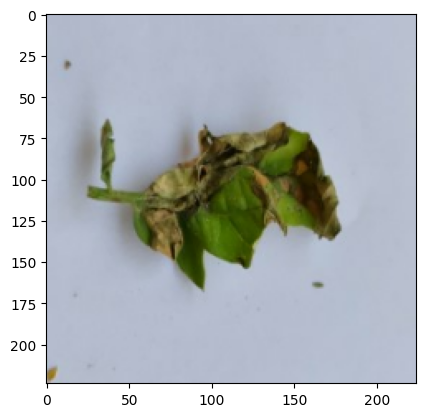

In [ ]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the actual label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the predicted labels are within the valid range
    y_pred_indices = np.argmax(batch_prediction, axis=1)
    for i in range(len(y_pred_indices)):
        if 0 <= y_pred_indices[i] < len(class_names):
            print(f"predicted label {i + 1}:", class_names[y_pred_indices[i]])
        else:
            print(f"Invalid predicted index {i + 1}:", y_pred_indices[i])




In [ ]:
predicted_labels = []
actual_labels = []

for images, labels in test_ds:
    # Predict class for each image in the batch
    y_pred = model.predict(images)
    y_pred = np.argmax(y_pred, axis=1)

    # Append predicted and actual class labels to lists
    for i in range(len(labels)):
        predicted_labels.append(class_names[y_pred[i]])
        actual_labels.append(class_names[labels[i]])

plt.show()

1/1 [==============================] - 0s 37ms/step


# Confusion Matrix

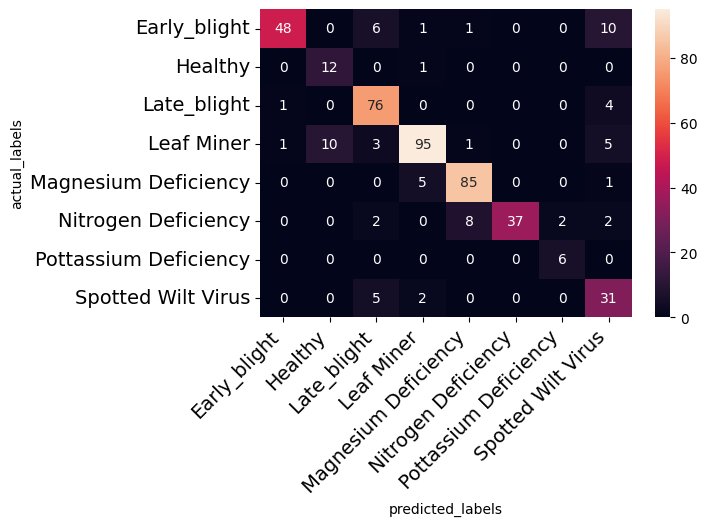

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('actual_labels')
    plt.xlabel('predicted_labels')
    plt.savefig('confusion.png')

cm = confusion_matrix(predicted_labels,actual_labels)
print_confusion_matrix(cm,['Early_blight', 'Healthy', 'Late_blight','Leaf Miner','Magnesium Deficiency','Nitrogen Deficiency','Pottassium Deficiency','Spotted Wilt Virus'])

In [ ]:
# Ensure that the length of both lists is the same
if len(predicted_labels) == len(actual_labels):
    correct_predictions = sum(p == a for p, a in zip(predicted_labels, actual_labels))
    total_predictions = len(predicted_labels)

    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("Error: The number of elements in predicted_labels and actual_labels must be the same.")

Accuracy: 88.72%


# Precision,Recall, F1 Score

In [ ]:
# Calculating Precision-Recall-F1
# You can use 'macro', 'weighted', or 'micro' as per your requirement

if len(predicted_labels) == len(actual_labels):
    # Calculate F1 score for multi-class classification

    precision = precision_score(actual_labels, predicted_labels, average='weighted')
    print(f"precision_score: {precision:.2f}")
    recall = recall_score(actual_labels, predicted_labels, average='weighted')
    print(f"Recall Score: {recall:.2f}")
    f1 = f1_score(actual_labels, predicted_labels, average='weighted')
    print(f"F1 Score: {f1:.2f}")

else:
    print("Error: The number of elements in predicted_labels and actual_labels must be the same.")

precision_score: 0.90
Recall Score: 0.89
F1 Score: 0.88


# ROC Curve

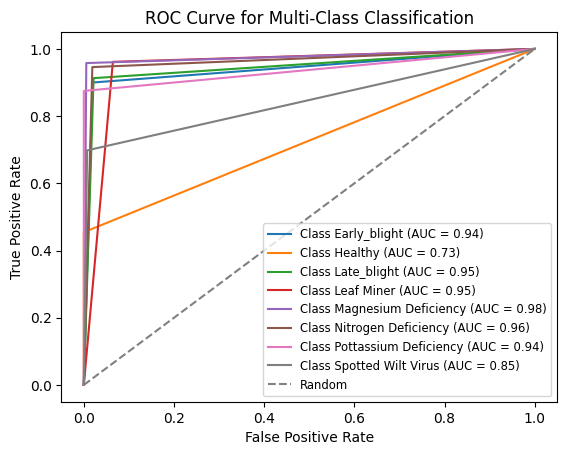

In [ ]:
# Convert class labels to binary matrix (one-hot encoding)
label_binarizer = LabelBinarizer()
actual_binary = label_binarizer.fit_transform(actual_labels)
predicted_binary = label_binarizer.transform(predicted_labels)

# Compute ROC AUC for each class
auc_scores = []
for i in range(len(label_binarizer.classes_)):
    auc = roc_auc_score(actual_binary[:, i], predicted_binary[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(actual_binary[:, i], predicted_binary[:, i])
    plt.plot(fpr, tpr, label=f"Class {label_binarizer.classes_[i]} (AUC = {auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')

# Set the legend fontsize to a smaller value
plt.legend(fontsize='small')
plt.savefig('ROC.png')

plt.show()


# Average AUC

In [ ]:
# Create a DataFrame with class names and corresponding AUC scores
auc_table = pd.DataFrame({'Class': class_names, 'AUC Score': auc_scores})

# Print the table
print(auc_table)

# Average AUC across all classes
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc:.2f}")

                   Class  AUC Score
0           Early_blight   0.940268
1                Healthy   0.727273
2            Late_blight   0.945682
3             Leaf Miner   0.948556
4   Magnesium Deficiency   0.976215
5    Nitrogen Deficiency   0.963539
6  Pottassium Deficiency   0.937500
7     Spotted Wilt Virus   0.845380
Average AUC: 0.91


In [ ]:
print(classification_report(actual_labels, predicted_labels))

                       precision    recall  f1-score   support

         Early_blight       0.73      0.96      0.83        50
              Healthy       0.92      0.55      0.69        22
          Late_blight       0.94      0.83      0.88        92
           Leaf Miner       0.83      0.91      0.87       104
 Magnesium Deficiency       0.93      0.89      0.91        95
  Nitrogen Deficiency       0.73      1.00      0.84        37
Pottassium Deficiency       1.00      0.75      0.86         8
   Spotted Wilt Virus       0.82      0.58      0.68        53

             accuracy                           0.85       461
            macro avg       0.86      0.81      0.82       461
         weighted avg       0.86      0.85      0.84       461



In [ ]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(test_ds)[1]
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

15/15 [==============================] - 3s 211ms/step - loss: 0.4429 - accuracy: 0.8872
Test Accuracy: 88.72%


# Save Model

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
